In [1]:
%matplotlib inline

from scipy.odr import *
from scipy.stats import *
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import ast
from multiprocessing import Pool

import scipy

from IPython import display
from matplotlib.patches import Rectangle

from sklearn.metrics import mean_squared_error
import json

import scipy.stats as st
from sklearn.metrics import r2_score


from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

import copy

from sklearn.model_selection import LeaveOneOut, LeavePOut

from multiprocessing import Pool
import cv2

In [2]:
dfAll = pd.read_pickle("AllData.pkl")
dfAll.head()

,userID,Timestamp,Current_Task,Task_amount,TaskID,VersionID,RepetitionID,Actual_Data,Is_Pause,Image
0,2,1545153912946,0,34,0,0,0,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 225, 1, 1, 1..."
1,2,1545153912955,0,34,0,0,0,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 225, 1, 1, 1..."
2,2,1545153912995,0,34,0,0,0,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 225, 1, 1, 1..."
3,2,1545153913034,0,34,0,0,0,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 225, 1, 1, 1..."
4,2,1545153913076,0,34,0,0,0,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 225, 1, 1, 1..."


In [3]:
df_actual = dfAll[(dfAll.Actual_Data == True) & (dfAll.Is_Pause == False)]
df_actual.head()

,userID,Timestamp,Current_Task,Task_amount,TaskID,VersionID,RepetitionID,Actual_Data,Is_Pause,Image
5401,2,1545154134174,1,680,20,2,0,True,False,"[0, 0, 0, 0, 0, 0, 160, 0, 1, 0, 0, 0, 0, 0, 0..."
5402,2,1545154134208,1,680,20,2,0,True,False,"[0, 0, 0, 0, 0, 0, 160, 0, 1, 0, 0, 0, 0, 0, 0..."
5403,2,1545154134246,1,680,20,2,0,True,False,"[0, 0, 0, 0, 0, 0, 160, 0, 1, 0, 0, 0, 0, 0, 0..."
5404,2,1545154134284,1,680,20,2,0,True,False,"[0, 0, 0, 0, 0, 0, 160, 0, 1, 0, 0, 0, 0, 0, 0..."
5405,2,1545154134324,1,680,20,2,0,True,False,"[0, 0, 0, 0, 0, 0, 160, 0, 1, 0, 0, 0, 0, 0, 0..."


In [4]:
print("all: %s, actual data: %s" % (len(dfAll), len(df_actual)))

all: 120353, actual data: 96438


In [5]:
crop_frame = 5

def detect_blobs(image):
    image = image.reshape(27, 15)
    temp, thresh = cv2.threshold(cv2.bitwise_not(image), 200, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [a for a in contours if cv2.contourArea(a) > 5 and cv2.contourArea(a) < 255]
    if len(contours) > 0:
        max_contour = max(contours, key=lambda a: cv2.contourArea(a))
        M = cv2.moments(max_contour)
        cx = round(M['m10'] / M['m00'])
        cy = round(M['m01'] / M['m00'])
        croped_im = image[max(cy - crop_frame, 0):min(cy + crop_frame, 27), max(cx - crop_frame, 0):min(cx + crop_frame, 15)].copy()
        # pad border
        croped_im = cv2.copyMakeBorder(croped_im, max(-1 * (cy - crop_frame), 0), max(-1 * (image.shape[0] - (cy + crop_frame)), 0), max(-1 * (cx - crop_frame), 0), max(-1 * (image.shape[1] - (cx + crop_frame)), 0), cv2.BORDER_CONSTANT, value=0)
        return (1, [croped_im])
    else:
        return (0, [np.zeros((2 * crop_frame) ** 2).reshape((2 * crop_frame, 2 * crop_frame))])

In [6]:
%%time
pool = Pool(4)
df_croped = df_actual.copy()
temp_blobs = pool.map(detect_blobs, df_actual.Image)
df_croped["BlobCount"] = [a[0] for a in temp_blobs]
df_croped["Blobs"] = [a[1] for a in temp_blobs]
df_croped.head()

CPU times: user 967 ms, sys: 172 ms, total: 1.14 s
Wall time: 1.49 s


In [7]:
df_blobs = df_croped[df_croped.BlobCount == 1]
print("detected blobs: %s" % len(df_blobs))
df_blobs.head()

detected blobs: 26031


,userID,Timestamp,Current_Task,Task_amount,TaskID,VersionID,RepetitionID,Actual_Data,Is_Pause,Image,BlobCount,Blobs
5471,2,1545154137056,1,680,20,2,0,True,False,"[0, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, ...",1,"[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0,..."
5472,2,1545154137101,1,680,20,2,0,True,False,"[0, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, ...",1,"[[[2, 1, 0, 0, 0, 2, 1, 1, 0, 0], [0, 0, 0, 1,..."
5473,2,1545154137134,1,680,20,2,0,True,False,"[0, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, ...",1,"[[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0,..."
5474,2,1545154137174,1,680,20,2,0,True,False,"[0, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, ...",1,"[[[0, 2, 0, 0, 1, 4, 1, 0, 1, 0], [0, 1, 0, 0,..."
5475,2,1545154137214,1,680,20,2,0,True,False,"[0, 0, 1, 3, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, ...",1,"[[[2, 1, 1, 1, 2, 4, 1, 0, 0, 0], [0, 1, 1, 0,..."


In [8]:
df_blobs.to_pickle("df_blobs.pkl")

# display blobs

<Figure size 432x288 with 0 Axes>

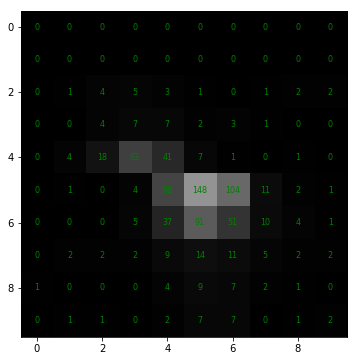

In [9]:
plt.clf()
plt.figure(figsize=(6, 6))
ax = plt.gca()
data_point = 100
data = df_blobs.Blobs.iloc[data_point][0]
plt.imshow(data, cmap='gray', vmin=0, vmax=255)
# Loop over data dimensions and create text annotations.
for i in range(0, data.shape[0]):
    for j in range(0, data.shape[1]):
        text = ax.text(j, i, int(data[i, j]),
                       ha="center", va="center", color="green", fontsize=8)
plt.savefig("input.png", bbox_inches='tight')
plt.show()